In [1]:
%matplotlib inline
import gym
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical

/home/aman/Documents/conda_gym/env_gym/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from matplotlib import pyplot as plt
import numpy as np

In [3]:
from IPython.display import clear_output, display

In [4]:
env = gym.make('BreakoutDeterministic-v4')

In [5]:
def show_state(env, step=0, info=""):
    
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Atari Breakout")
    plt.axis('off')

    clear_output(wait=True)
    display(plt.gcf())


In [6]:
_ = env.reset()

In [7]:
np.ones(4).reshape(-1, 4).shape

(1, 4)

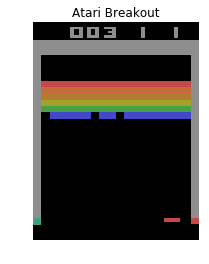

<Figure size 432x288 with 0 Axes>

In [19]:

# Create a breakout environment

# Reset it, returns the starting frame
frame = env.reset()
# frame = preprocess(frame)
# frame = np.stack([frame] * 4, axis=2)
is_done = False
while not is_done:
    # Perform a random action, returns the new frame, reward and whether the game is over
    
#     action = np.argmax(m.predict([frame.reshape(-1, 105, 80, 4), np.ones(4).reshape(-1, 4)]))
    action = env.action_space.sample()
    next_frame, reward, is_done, _ = env.step(action)
    print(action)
#     next_frame = preprocess(next_frame)
#     next_frame = np.append(frame[:, :, 1:], np.expand_dims(next_frame, axis=2), axis=2)
    show_state(env.env)
    plt.clf()
  
    

In [9]:
def to_grayscale(img):
    return np.mean(img, axis=2).astype(np.uint8)

def downsample(img):
    return img[::2, ::2]

def preprocess(img):
    return to_grayscale(downsample(img))

def transform_reward(reward):
    return np.sign(reward)

In [10]:
def fit_batch(model, gamma, batch):
    start_states = np.array([])
    actions = np.array([])
    next_states = np.array([])
    rewards = np.array([])
    is_terminal = np.array([])
    
    for ss, a, ns, r, t in batch:
        if start_states.size > 0:
            start_states = np.vstack((start_states, np.expand_dims(ss, 0)))
            next_states = np.vstack((next_states, np.expand_dims(ns, 0)))
        else:
            start_states = np.expand_dims(ss, 0)
            next_states = np.expand_dims(ns, 0)
        actions = np.append(actions, a)
        rewards = np.append(rewards, r)
        is_terminal = np.append(is_terminal, t)
        

    actions = to_categorical(actions, 4)
    
    # First, predict the Q values of the next states. Note how we are passing ones as the mask.
    next_Q_values = model.predict([next_states, actions])
#     for i, terminal in enumerate(is_terminal):
#         if terminal:
#             next_Q_values[i][np.argmax(actions[i])] = 0
    
    # The Q values of each start state is the reward + gamma * the max next state Q value
    Q_values = rewards + gamma * np.max(next_Q_values, axis=1)
    # Fit the keras model. Note how we are passing the actions as the mask and multiplying
    # the targets by the actions.
    model.fit([start_states, actions], actions * Q_values[:, None],epochs=1, batch_size=len(start_states), verbose=0)

In [11]:
def atari_model(n_actions):
    ATARI_SHAPE = (105, 80, 4)

    # With the functional API we need to define the inputs.
    frames_input = keras.layers.Input(ATARI_SHAPE, name='frames')
    actions_input = keras.layers.Input((n_actions,), name='mask')

    # Assuming that the input frames are still encoded from 0 to 255. Transforming to [0, 1].
    normalized = keras.layers.Lambda(lambda x: x / 255.0)(frames_input)
    
    # "The first hidden layer convolves 16 8×8 filters with stride 4 with the input image and applies a rectifier nonlinearity."
    conv_1 = keras.layers.Conv2D(16, (8, 8), activation='relu', strides=(4, 4))(normalized)
    
    # "The second hidden layer convolves 32 4×4 filters with stride 2, again followed by a rectifier nonlinearity."
    conv_2 = keras.layers.Conv2D(32, (4, 4), activation="relu", strides=(2, 2))(conv_1)
    
    # Flattening the second convolutional layer.
    conv_flattened = keras.layers.Flatten()(conv_2)
    # "The final hidden layer is fully-connected and consists of 256 rectifier units."
    hidden = keras.layers.Dense(256, activation='relu')(conv_flattened)
    # "The output layer is a fully-connected linear layer with a single output for each valid action."
    output = keras.layers.Dense(n_actions)(hidden)
    # Finally, we multiply the output by the mask!
    filtered_output = keras.layers.multiply([output, actions_input])

    model = keras.models.Model(inputs=[frames_input, actions_input], outputs=filtered_output)
    optimizer = optimizer=keras.optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)
    model.compile(optimizer, loss='mse')
    
    return model

In [12]:
class RingBuf:
    def __init__(self, size):
        # Pro-tip: when implementing a ring buffer, always allocate one extra element,
        # this way, self.start == self.end always means the buffer is EMPTY, whereas
        # if you allocate exactly the right number of elements, it could also mean
        # the buffer is full. This greatly simplifies the rest of the code.
        self.data = [None] * (size + 1)
        self.start = 0
        self.end = 0
        
    def append(self, element):
        self.data[self.end] = element
        self.end = (self.end + 1) % len(self.data)
        # end == start and yet we just added one element. This means the buffer has one
        # too many element. Remove the first element by incrementing start.
        if self.end == self.start:
            self.start = (self.start + 1) % len(self.data)
    
    def add(self, state, action, next_state, reward, done):
        self.append((state, action, next_state, reward, done))
    
    def __getitem__(self, idx):
        return self.data[(self.start + idx) % len(self.data)]
    
    def __len__(self):
        if self.end < self.start:
            return self.end + len(self.data) - self.start
        else:
            return self.end - self.start
        
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

In [13]:
def sample_data(memory, batch_size):
    result = [memory[i] for i in np.random.randint(0, len(memory), batch_size)]
    return np.array(result)

In [14]:
m = atari_model(env.action_space.n)

In [15]:
memory = RingBuf(5000)
epsilon = 1.0
epsilon_decay = 0.90

for e in range(100):
    state = env.reset()
    state = preprocess(state)
    state = np.stack([state] * 4, axis=2)
    is_done = False
    epsilon *= epsilon_decay
    r = 0
    while not is_done:
        
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = m.predict([state.reshape(-1, 105, 80, 4), np.ones(4).reshape(-1, 4)])
            action = np.argmax(action, 1)
        next_state, reward, is_done, _ = env.step(action)
#         reward = reward if not is_done else 0
        next_state = preprocess(next_state)
        next_state = np.append(state[:, :, 1:], np.expand_dims(next_state, axis=2), axis=2)
        action = int(action)            
        memory.add(state, action, next_state, reward, is_done)
        r += reward
        if is_done:
            print("episode: {}/100, memory: {}, reward: {}"
                      .format(e, len(memory), r))
        
        if len(memory) > 32:
            minibatch = sample_data(memory, 32)
            fit_batch(m, 0.99, minibatch)

/home/aman/Documents/conda_gym/env_gym/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


episode: 0/100, memory: 317, reward: 4.0
episode: 1/100, memory: 469, reward: 0.0
episode: 2/100, memory: 628, reward: 1.0
episode: 3/100, memory: 777, reward: 0.0
episode: 4/100, memory: 1017, reward: 2.0
episode: 5/100, memory: 1165, reward: 0.0
episode: 6/100, memory: 1389, reward: 2.0
episode: 7/100, memory: 1537, reward: 0.0
episode: 8/100, memory: 1704, reward: 0.0
episode: 9/100, memory: 1884, reward: 1.0
episode: 10/100, memory: 2162, reward: 3.0
episode: 11/100, memory: 2347, reward: 1.0
episode: 12/100, memory: 2516, reward: 0.0
episode: 13/100, memory: 2667, reward: 0.0
episode: 14/100, memory: 2892, reward: 0.0
episode: 15/100, memory: 3175, reward: 2.0
episode: 16/100, memory: 3568, reward: 11.0
episode: 17/100, memory: 3860, reward: 7.0
episode: 18/100, memory: 4240, reward: 8.0
episode: 19/100, memory: 4783, reward: 7.0
episode: 20/100, memory: 5000, reward: 9.0
episode: 21/100, memory: 5000, reward: 9.0
episode: 22/100, memory: 5000, reward: 11.0
episode: 23/100, memory

KeyboardInterrupt: 

In [18]:
m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
frames (InputLayer)             (None, 105, 80, 4)   0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 105, 80, 4)   0           frames[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 25, 19, 16)   4112        lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 11, 8, 32)    8224        conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 

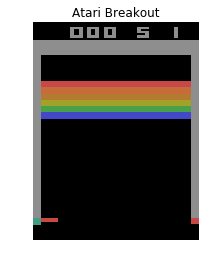

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [18]:

# Create a breakout environment

# Reset it, returns the starting frame
frame = env.reset()
frame = preprocess(frame)
frame = np.stack([frame] * 4, axis=2)
is_done = False
while not is_done:
    # Perform a random action, returns the new frame, reward and whether the game is over
    
    action = np.argmax(m.predict([frame.reshape(-1, 105, 80, 4), np.ones(4).reshape(-1, 4)]))
#     action = env.action_space.sample()
    next_frame, reward, is_done, _ = env.step(action)
    next_frame = preprocess(next_frame)
    next_frame = np.append(frame[:, :, 1:], np.expand_dims(next_frame, axis=2), axis=2)
    show_state(env.env)
    plt.clf()
  
    